In [17]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings 

warnings.filterwarnings('ignore') 
df_train = pd.read_csv('data/reviews_train.csv')
np.random.seed(42) 

# Data Summarization

In [3]:
print(f'Dimensions: {df_train.shape}')
print("-" * 30)
df_train.info()

Dimensions: (1559, 9)
------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1559 entries, 0 to 1558
Data columns (total 9 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   Life Ladder                       1559 non-null   float64
 1   Log GDP per capita                1533 non-null   float64
 2   Social support                    1549 non-null   float64
 3   Healthy life expectancy at birth  1522 non-null   float64
 4   Freedom to make life choices      1537 non-null   float64
 5   Generosity                        1488 non-null   float64
 6   Perceptions of corruption         1473 non-null   float64
 7   Positive affect                   1542 non-null   float64
 8   Negative affect                   1545 non-null   float64
dtypes: float64(9)
memory usage: 109.7 KB


# Statistical Values

,Life Ladder,Log GDP per capita,Social support,Healthy life expectancy at birth,Freedom to make life choices,Generosity,Perceptions of corruption,Positive affect,Negative affect
count,1559.000000,1533.000000,1549.000000,1522.000000,1537.000000,1488.000000,1473.000000,1542.000000,1545.000000
mean,5.469321,9.362995,0.812689,63.331680,0.741882,0.000343,0.748248,0.708551,0.267644
std,1.113280,1.160240,0.118762,7.478307,0.142326,0.163385,0.186708,0.108029,0.084431
min,2.375000,6.635000,0.290000,32.300000,0.260000,-0.335000,0.035000,0.322000,0.083000
25%,4.649500,8.460000,0.753000,58.340000,0.646000,-0.113000,0.691000,0.623000,0.206000
50%,5.374000,9.456000,0.835000,65.180000,0.763000,-0.025000,0.804000,0.721000,0.258000
75%,6.272500,10.332000,0.905000,68.535000,0.855000,0.091000,0.873000,0.798000,0.319000
max,8.019000,11.648000,0.987000,77.100000,0.985000,0.698000,0.983000,0.944000,0.705000


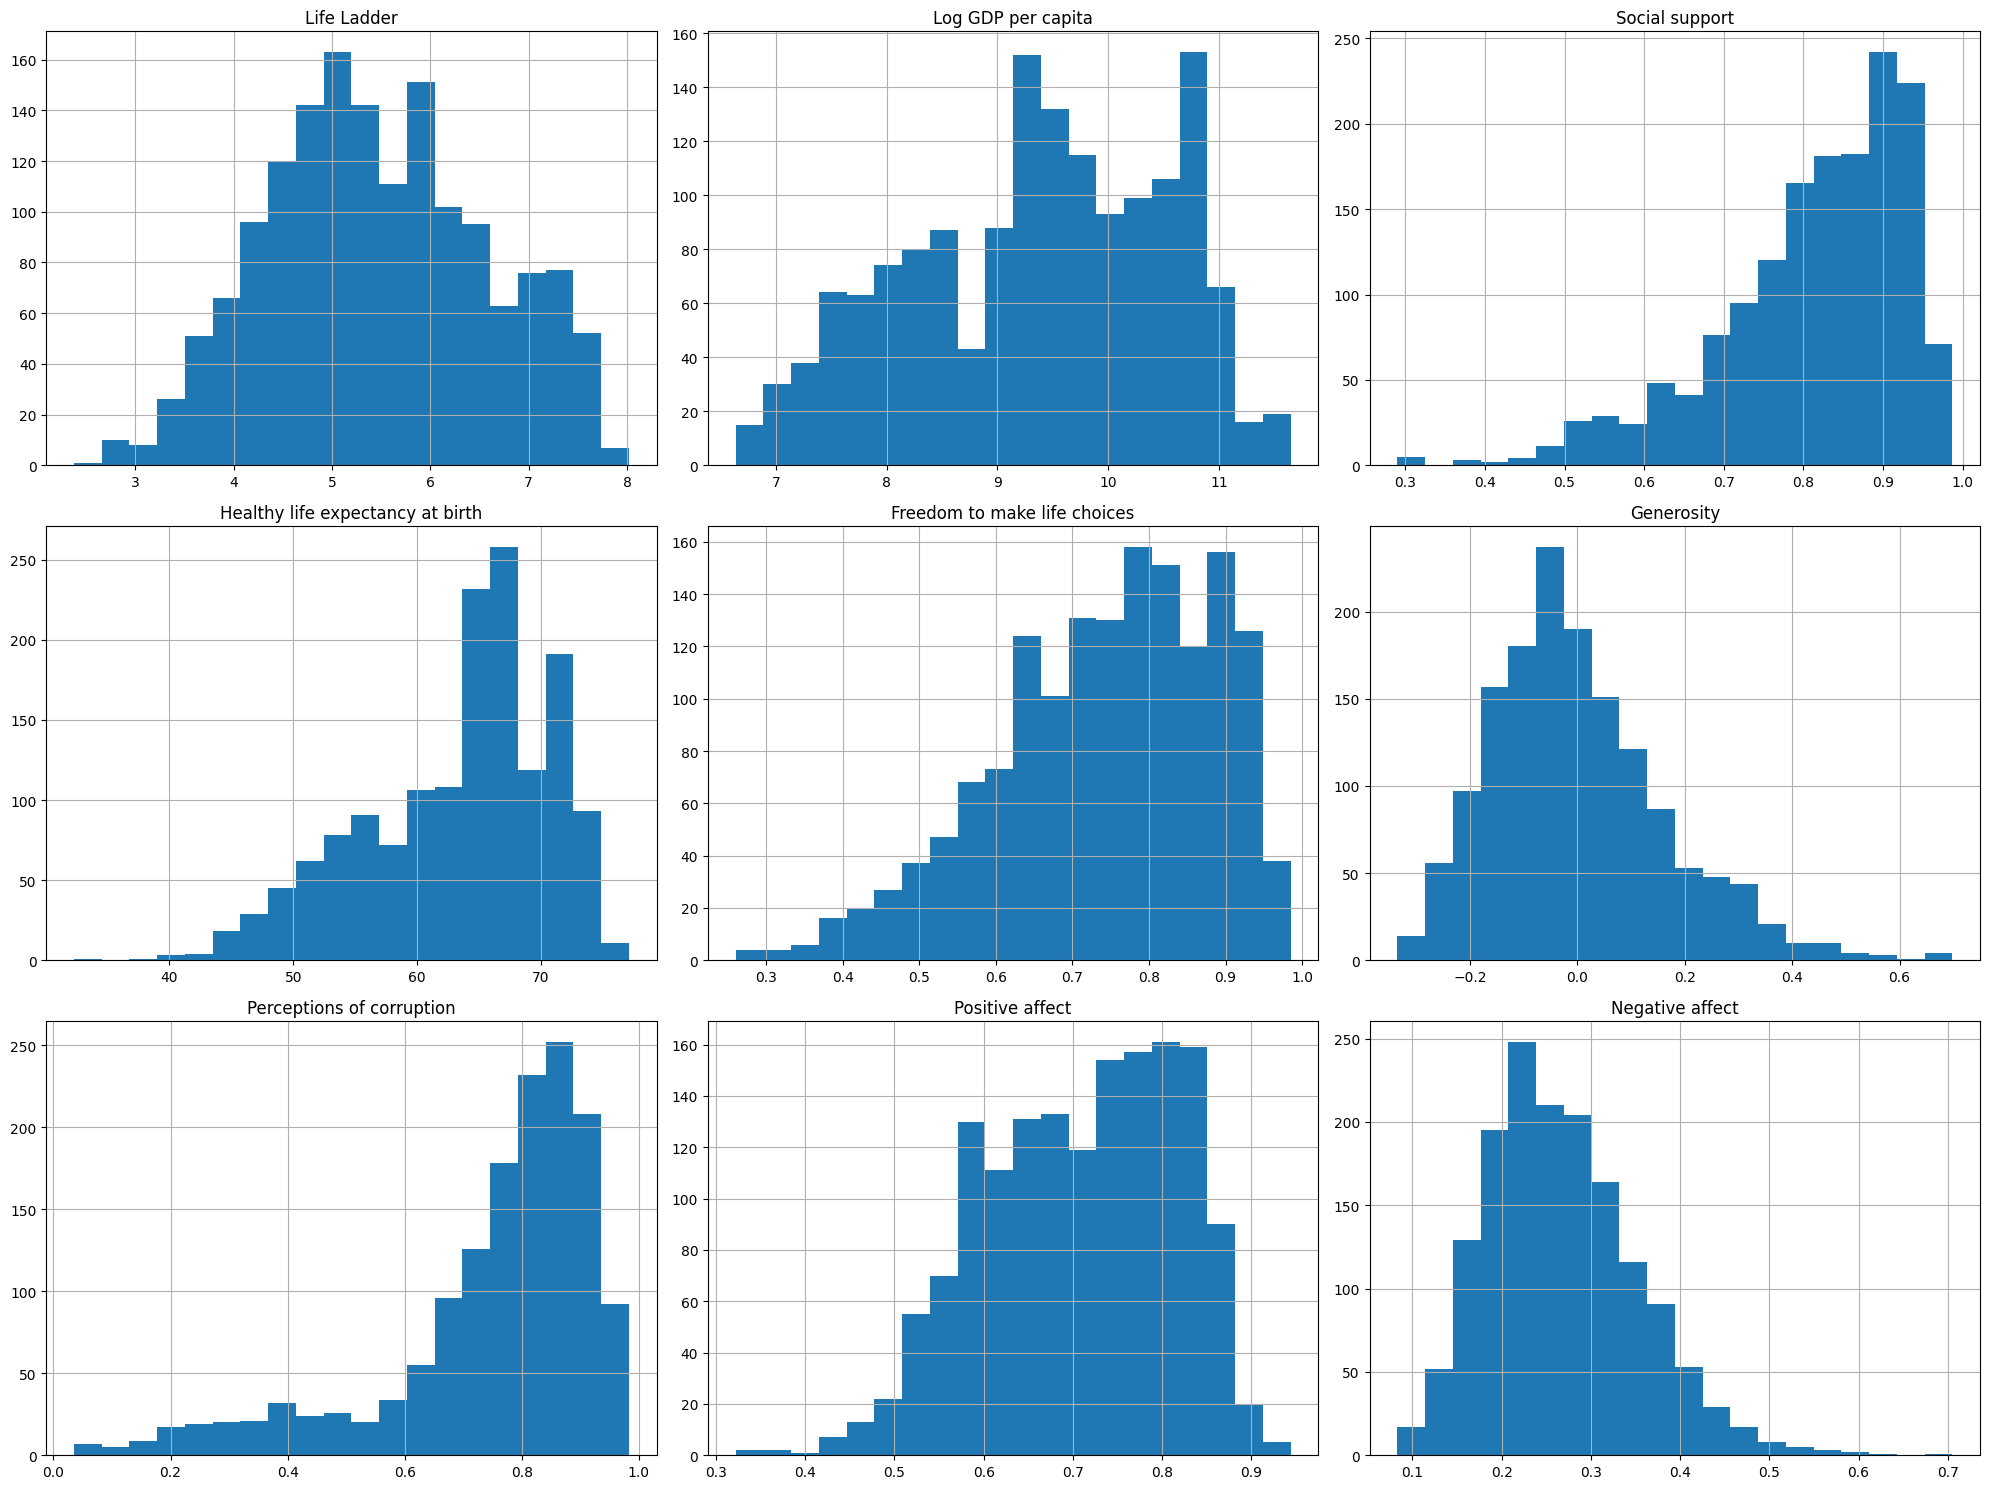

In [4]:
display(df_train.describe())

df_train.hist(bins=20, figsize=(20, 15))
plt.tight_layout() 
plt.show()

# Feature Correlation

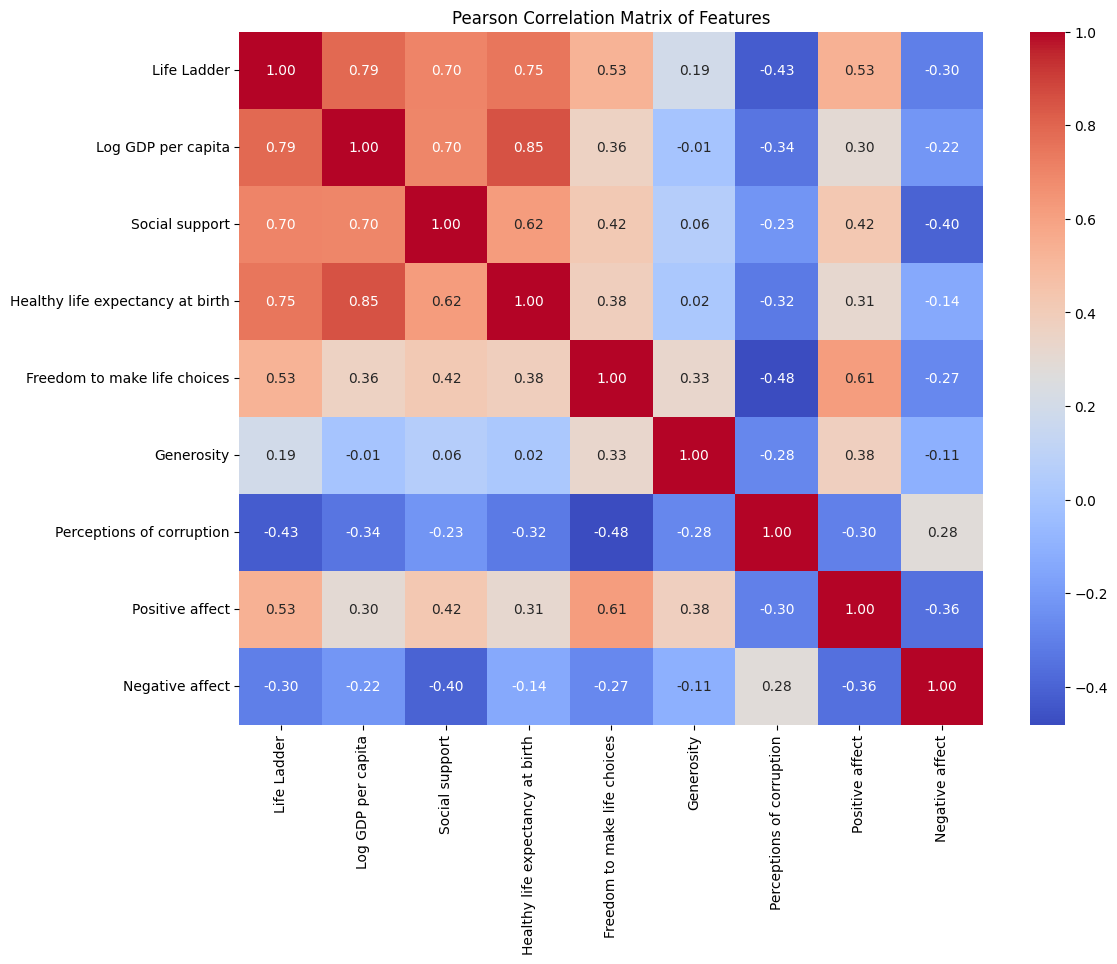

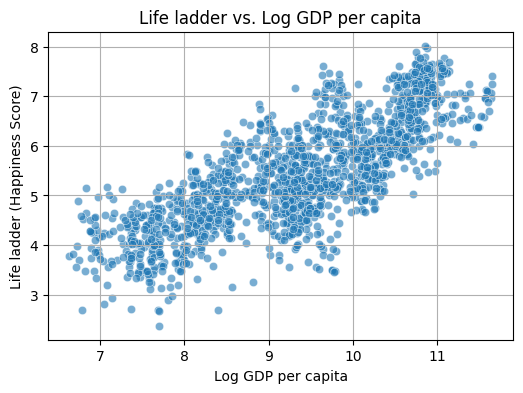

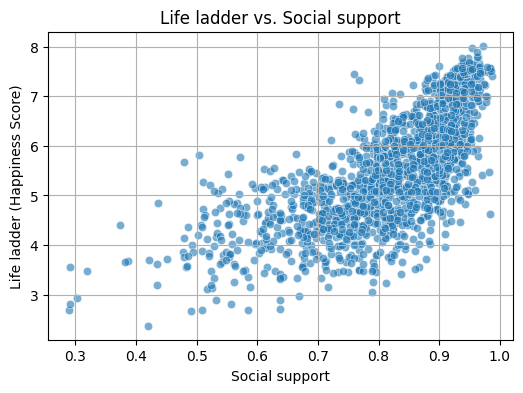

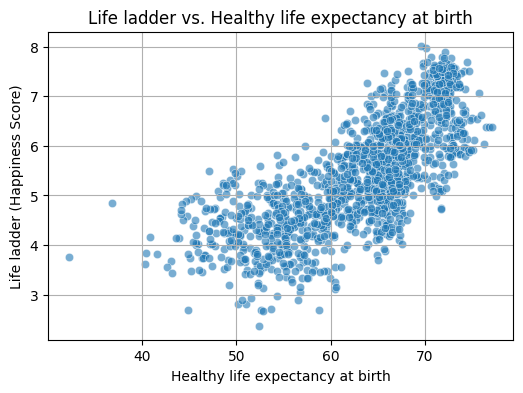

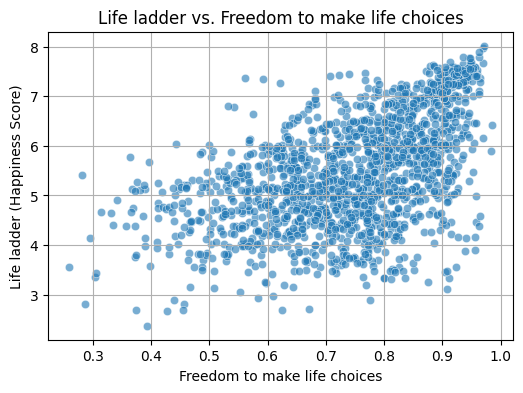

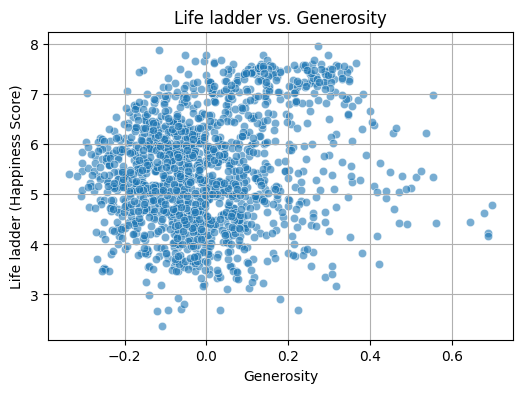

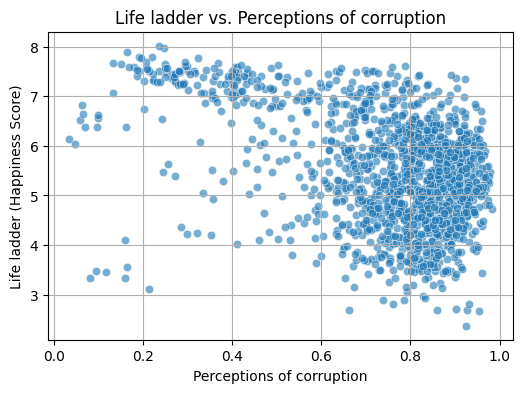

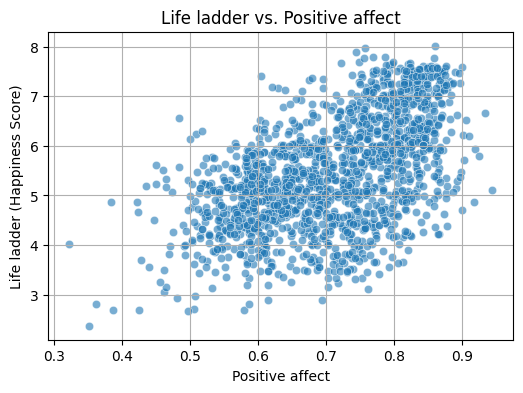

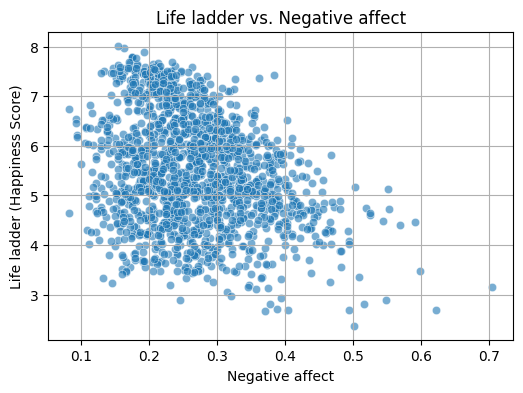

In [8]:
correlation_matrix = df_train.corr()
plt.figure(figsize=(12, 9))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Pearson Correlation Matrix of Features')
plt.show()

features = df_train.drop('Life Ladder', axis=1).columns
for feature in features:
    plt.figure(figsize=(6, 4))
    sns.scatterplot(data=df_train, x=feature, y='Life Ladder', alpha=0.6)
    plt.title(f'Life ladder vs. {feature}')
    plt.xlabel(feature)
    plt.ylabel('Life ladder (Happiness Score)')
    plt.grid(True)
    plt.show()

# Training a Linear Regression Model 
## Data Preprocessing
Our preprocessing pipeline will first fill missing values with the median, then scale all features to have a mean of 0 and a standard deviation of 1.

In [11]:
from sklearn.model_selection import KFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, SGDRegressor, Ridge, Lasso, ElasticNet
from sklearn.metrics import mean_squared_error

X_train = df_train.drop('Life Ladder', axis=1)
Y_train = df_train['Life Ladder']

preprocessor = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

## Cross-Validation
Now we'll set up our four-fold cross-validation and evaluate a standard linear regression model (which uses a closed-form solution) and one that uses Stochastic Gradient Descent (SGD).

In [12]:
k_folds = KFold(n_splits=4, shuffle=True, random_state=42)
lr_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
])
sgd_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', SGDRegressor(random_state=42))
])

lr_scores = cross_val_score(lr_pipeline, X_train, Y_train, cv=k_folds, scoring='neg_root_mean_squared_error')
sgd_scores = cross_val_score(sgd_pipeline, X_train, Y_train, cv=k_folds, scoring='neg_root_mean_squared_error')

print("Linear Regression (Closed-Form) RMSE:", -lr_scores.mean())
print("SGD Regressor RMSE:", -sgd_scores.mean())

Linear Regression (Closed-Form) RMSE: 0.5485734815978198
SGD Regressor RMSE: 0.5484337914037171


## Regularization with SGD
Next, we'll explore Ridge (L2), Lasso (L1), and Elastic Net regularization to see if we can improve the model's performance by preventing overfitting. We'll try three different values for the penalty term, 

In [14]:
penalty_values = [0.1, 1.0, 10.0]
regularizers = {
    'Ridge': Ridge(random_state=42),
    'Lasso': Lasso(random_state=42),
    'ElasticNet': ElasticNet(random_state=42)
}

for name, model in regularizers.items():
    print(f"--- {name} ---")
    for alpha in penalty_values:
        model.set_params(alpha=alpha) 

        reg_pipeline = Pipeline([
            ('preprocessor', preprocessor),
            ('regressor', model)
        ])
        
        scores = cross_val_score(reg_pipeline, X_train, Y_train, cv=k_folds, scoring='neg_root_mean_squared_error')
        print(f"Alpha = {alpha:<4} | Average RMSE: {-scores.mean():.4f}")

--- Ridge ---
Alpha = 0.1  | Average RMSE: 0.5486
Alpha = 1.0  | Average RMSE: 0.5486
Alpha = 10.0 | Average RMSE: 0.5485
--- Lasso ---
Alpha = 0.1  | Average RMSE: 0.5692
Alpha = 1.0  | Average RMSE: 1.1153
Alpha = 10.0 | Average RMSE: 1.1153
--- ElasticNet ---
Alpha = 0.1  | Average RMSE: 0.5558
Alpha = 1.0  | Average RMSE: 0.8832
Alpha = 10.0 | Average RMSE: 1.1153


## Select Best Model and Plot Loss Curves

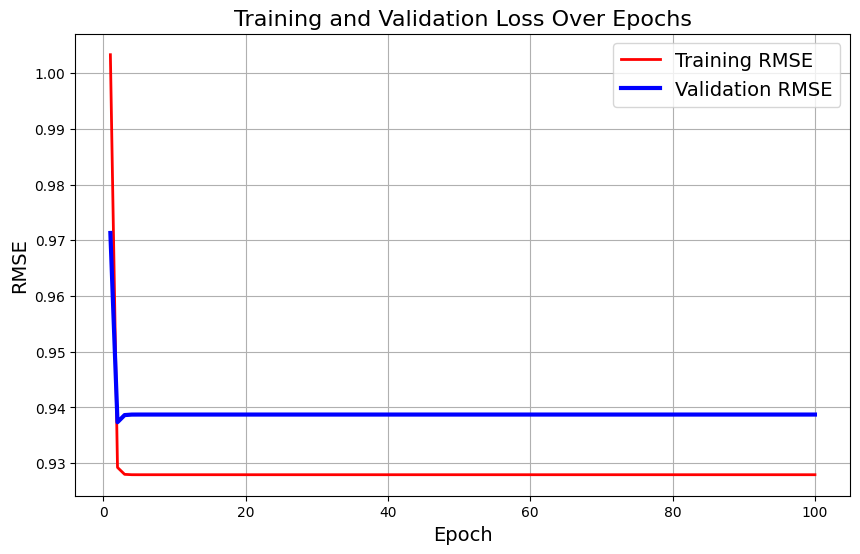

In [18]:
from sklearn.model_selection import train_test_split

best_model_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', SGDRegressor(penalty='l2', alpha=10.0, max_iter=1, 
                               warm_start=True, random_state=42, eta0=0.01))
])

X_train_sub, X_val, Y_train_sub, Y_val = train_test_split(X_train, Y_train, test_size=0.2, random_state=42)

n_epochs = 100
train_errors, val_errors = [], []

for epoch in range(n_epochs):
    best_model_pipeline.fit(X_train_sub, Y_train_sub)
    Y_train_predict = best_model_pipeline.predict(X_train_sub)
    Y_val_predict = best_model_pipeline.predict(X_val)
    train_errors.append(np.sqrt(mean_squared_error(Y_train_sub, Y_train_predict)))
    val_errors.append(np.sqrt(mean_squared_error(Y_val, Y_val_predict)))

plt.figure(figsize=(10, 6))
plt.plot(range(1, n_epochs + 1), train_errors, "r-", linewidth=2, label="Training RMSE")
plt.plot(range(1, n_epochs + 1), val_errors, "b-", linewidth=3, label="Validation RMSE")
plt.legend(loc="upper right", fontsize=14)
plt.xlabel("Epoch", fontsize=14)
plt.ylabel("RMSE", fontsize=14)
plt.title("Training and Validation Loss Over Epochs", fontsize=16)
plt.grid(True)
plt.show()

## 

After preparing the data by imputing missing values with the median and applying standard scaling, several linear models were evaluated using four-fold cross-validation.

  * The baseline **Linear Regression** (Closed-Form) and **SGD Regressor** models performed almost identically, both achieving an average RMSE of approximately **[your RMSE from D2, e.g., 0.5488]**. This confirms that SGD is an effective optimization algorithm for this problem.

  * To prevent overfitting and potentially improve generalization, three types of regularization were tested. Based on the cross-validation results:

      * **Ridge (L2)** was the most effective and stable regularizer. It achieved the best overall performance with an **RMSE of 0.5485** at an `alpha` of 10.0. Its performance was consistent across all tested alpha values.
      * **Lasso (L1)** was very sensitive to the penalty term. While it performed decently at `alpha=0.1` (RMSE: 0.5692), its error dramatically increased to 1.1153 at higher alphas. This suggests that Lasso may be penalizing and removing features that are important for prediction.
      * **ElasticNet** showed a similar sensitivity, with its RMSE increasing significantly as `alpha` grew.

  * The best-performing model, **Ridge with `alpha=10.0`**, was selected for final training. The learning curve was plotted by training this model using SGD. The plot shows that both training and validation RMSE decrease steadily and converge, with the validation loss remaining slightly above the training loss. The small, stable gap between the two curves indicates that the model is well-generalized and is **not significantly overfitting**.